<a href="https://colab.research.google.com/github/MoheEdeen/Deepfake-Detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deepfake Audio Detection Project
#### CMSC320: Introduction to Data Science  
**Contributors:** Mohe Edeen Abu Maizer, Safwah Ashraf
**Repository:** https://github.com/MoheEdeen/Deepfake-Detection
**Date:** July 2025

---

## Project Overview

This project investigates deepfake audio detection using supervised learning. We analyze labeled `.wav` files from the **Fake-or-Real (FoR)** dataset to extract acoustic features and distinguish between real and synthetic speech generated by advanced TTS models. Our goal is to perform data preprocessing, statistical analysis, and hypothesis testing to uncover distinguishing traits between authentic and fake voice recordings.

---

In [1]:
import pathlib
import pandas as pd
import numpy as np
import soundfile as sf
import scipy.stats as sc

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.utils import resample
from statsmodels.stats.proportion import proportions_ztest

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing

To begin, we extracted audio data from two separate directories, one containing normalized audio clips but balanced in terms of gender and class and normalized in terms of sample rate, volume and number of channels. (`for-norm`) and the other containing rerecorded versions; to simulate a scenario where an attacker sends an utterance through a voice channel such as a phone call or a voice message (`for-rerecorded`). Each version includes `training`, `testing`, and `validation` subfolders, which are further divided into `real` and `fake` classes.

Using a nested loop structure, we traversed each `.wav` file and used the `soundfile` library (`sf.info()`) to extract attributes such as:

- Full file path
- Dataset version (`norm` or `rerec`)
- Data split (`training`, `testing`, `validation`)
- Label (`real` or `fake`)
- Numeric label ID
- Duration (in seconds)
- Samplerate (Hz)

These entries were stored in a Pandas DataFrame.

# IMPORTANT NOTE:

This code is commented out as we saved the results to a csv file for faster processing, if you want to run these cells keep in mind they do take a lot of time to run.

---

In [3]:
# dataset_path = "/content/drive/MyDrive/CMSC320/Project"
# dataset_norm = pathlib.Path(dataset_path + "/for-norm/for-norm/")
# dataset_norm.mkdir(parents=True, exist_ok=True)
# dataset_rerec =pathlib.Path(dataset_path + "/for-rerec/for-rerecorded")
# dataset_rerec.mkdir(parents=True, exist_ok=True)

In [4]:
# rows = []

# for version_name, dataset_path in [("norm", dataset_norm), ("rerec", dataset_rerec)]:
#     for split_folder in dataset_path.iterdir():
#         for label_folder in split_folder.iterdir():
#             for wav_file in label_folder.iterdir():
#               curr_file_path = str(wav_file)
#               curr_version = version_name
#               curr_type_of_file = split_folder.name
#               curr_label = label_folder.name
#               curr_label_id = 1 if curr_label == "real" else 0
#               curr_sound_file = sf.info(wav_file)
#               curr_duration = curr_sound_file.duration
#               curr_samplerate = curr_sound_file.samplerate
#               curr_row = {"filepath": curr_file_path, "version": curr_version, "type": curr_type_of_file, "label": curr_label, "label_id": curr_label_id, "duration": curr_duration, "samplerate": curr_samplerate}
#               # print(curr_row)
#               rows.append(curr_row)
# df = pd.DataFrame(rows)
# display(df)


In [5]:
# from google.colab import files
# df.to_csv("audio_data.csv", index=False)
# files.download("audio_data.csv")

In [6]:
csv_file = "/content/drive/MyDrive/CMSC320/Project/audio_data.csv"
df = pd.read_csv(csv_file)
df.reset_index(drop=True, inplace=True)
display(df)

,filepath,version,type,label,label_id,duration,samplerate
0,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.190375,16000
1,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,1.443375,16000
2,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,3.116687,16000
3,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.540125,16000
4,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,3.261563,16000
...,...,...,...,...,...,...,...
18374,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.975313,16000
18375,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.985875,16000
18376,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.986250,16000
18377,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.920313,16000


# Dataset summary and Basic statistic

Before we dive into doing all sorts of analyis, it's important for us to look at the basic structure of our dataset. This will help us understand what kind of data we're working with. Below, we check some basic facts about our dataset, like how many total samples we have, how many features or columns are included in our dataset, whether there are any missing values or not etc. These simple checks are certainly going to help us catch any problems early!

Number of samples and features:

In [7]:
df.shape

(18379, 7)

From above code, we can see that we have 18379 samples and 7 features in our dataset. These numbers can increase or decrease as we start polishing our dataset to make it perfect for our machine learning model.

Checking for missing values in our dataset:

In [8]:
df.isnull().sum()

,0
filepath,0
version,0
type,0
label,0
label_id,0
duration,0
samplerate,0


Fortunately, we do not have any missing values in our dataset! That's good news for us.

Column names and types:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18379 entries, 0 to 18378
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filepath    18379 non-null  object 
 1   version     18379 non-null  object 
 2   type        18379 non-null  object 
 3   label       18379 non-null  object 
 4   label_id    18379 non-null  int64  
 5   duration    18379 non-null  float64
 6   samplerate  18379 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 1005.2+ KB


If we want to take a quick glance at all the feautres we have in our dataset and get information about them, the above table is perfect for that.

Summary statistics:

In [10]:
df.describe()

,label_id,duration,samplerate
count,18379.000000,18379.000000,18379.0
mean,0.483051,1.984909,16000.0
std,0.499726,0.521096,0.0
min,0.000000,0.375625,16000.0
25%,0.000000,1.924500,16000.0
50%,0.000000,1.979688,16000.0
75%,1.000000,1.993313,16000.0
max,1.000000,38.683437,16000.0


The above code shows us stats like mean, minimum, maximum, standard deviation etc. for all numeric columns. We can use this to understand the overall range of our data if needed, spot any unusual values, and get a quick summary of the dataset's distribution!

# Dealing with outliers

To better understand how audio duration differs between real and fake samples, we use matplotlib to plot a box and whisker plot of the `duration` feature grouped by label.

When looking at the boxplot for the duration grouped by the audio clips, we can see that both types share a similar median which is around 2 second clips. However there are some outliers as seen by the second plot that can go more than 20 seconds (for only one type).

Such outliers would cause some issues down the line if we do not exclude them, as our model might be trained that the longer the clip the more likely it is real, which is untrue. This can be concluded because for the fake audio samples plot, the outliers do not exceed 6 seconds (unlike the real), yet they do go as low as 0.1 seconds unlike the real clips.

We can also see that for the real audio sample clips, there is a much tighter quartile range, unlike the fake ones which vary more widely.



/tmp/ipython-input-11-3143717109.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
/tmp/ipython-input-11-3143717109.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])


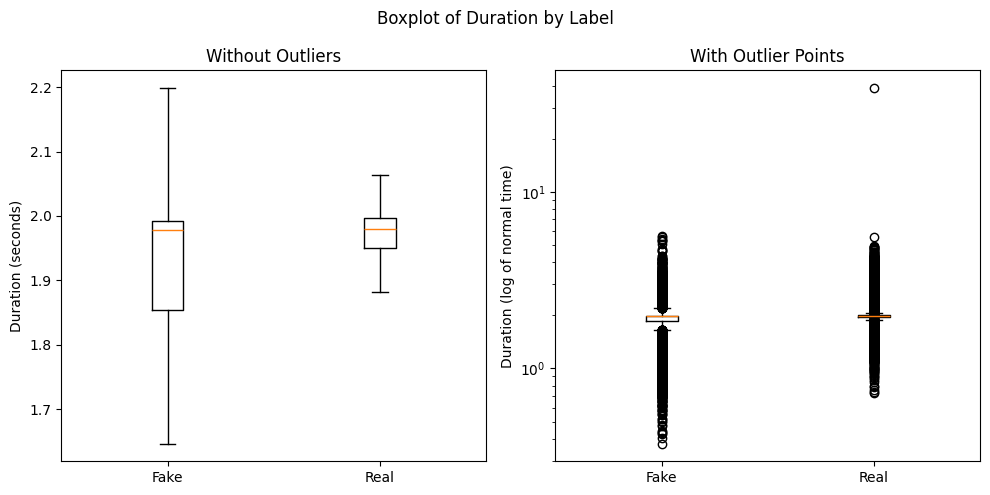

In [11]:
grouped_label_duration = [df[df["label"] == "fake"]["duration"], df[df["label"] == "real"]["duration"]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
axs[0].set_title("Without Outliers")
axs[0].set_ylabel("Duration (seconds)")

axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])
axs[1].set_title("With Outlier Points")
axs[1].set_ylabel("Duration (log of normal time)")
axs[1].set_yscale("log")

fig.suptitle("Boxplot of Duration by Label")
plt.tight_layout()
plt.show()

Looking at the graph, it is clear that the distribution between fake and real audio distribution is not valid or not ideal as there exists extreme outliers that go up to 30 seconds in the real type. We have to fix this.

#### Removing Outliers from Duration

Now that we can see how the duration is distributed, we want to remove the outliers before moving on. The reason for this is to make sure our model doesn't learn patterns that are not going to be helpful in making accurate predictions but most importantly, we want to make sure our model doesn't give us unreliable result. For example, if some real clips are way too long, the model might think real means longer, which is not true. We calculate the IQR (interquartile range) for both fake and real durations to find these outliers. Any duration that is way too small or too large (beyond the lower or upper fence) will be removed from the dataframe.

In [12]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

fake_duration = np.log2(df[df["label"] == "fake"]["duration"])
real_duration = np.log2(df[df["label"] == "real"]["duration"])

Q1_fake = fake_duration.quantile(0.25)
Q3_fake = fake_duration.quantile(0.75)

Q1_real = real_duration.quantile(0.25)
Q3_real = real_duration.quantile(0.75)

IQR_fake = Q3_fake - Q1_fake
IQR_real = Q3_real - Q1_real

lower_fake_fence = Q1_fake - (3 * IQR_fake)
upper_fake_fence = Q3_fake + (3 * IQR_fake)

lower_real_fence = Q1_real - (3 * IQR_real)
upper_real_fence = Q3_real + (3 * IQR_real)

upper_fake_array = np.where((df["label"] == "fake") & (np.log2(df["duration"]) >= upper_fake_fence))[0]
lower_fake_array = np.where((df["label"] == "fake") & (np.log2(df["duration"]) <= lower_fake_fence))[0]

upper_real_array = np.where((df["label"] == "real") & (np.log2(df["duration"]) >= upper_real_fence))[0]
lower_real_array = np.where((df["label"] == "real") & (np.log2(df["duration"]) <= lower_real_fence))[0]

df.drop(index=upper_fake_array, inplace=True)
df.drop(index=lower_fake_array, inplace=True)

df.drop(index=upper_real_array, inplace=True)
df.drop(index=lower_real_array, inplace=True)

print(upper_fake_fence, lower_real_fence, upper_real_fence, lower_real_fence)
df.reset_index(drop=True, inplace=True)
display(df)

1.305635921629112 0.8642228714769554 1.0969957505962125 0.8642228714769554


,filepath,version,type,label,label_id,duration,samplerate
0,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,1.932500,16000
1,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.083188,16000
2,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.084125,16000
3,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.037500,16000
4,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.028500,16000
...,...,...,...,...,...,...,...
14024,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.975313,16000
14025,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.985875,16000
14026,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.986250,16000
14027,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,real,1,1.920313,16000


### Plotting Duration Distribution After Outlier Removal

After removing outliers, we now replot the boxplot to see how the cleaned data
looks like. This helps us check if our removal process worked and if the distributions look more balanced.

/tmp/ipython-input-13-3143717109.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
/tmp/ipython-input-13-3143717109.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])


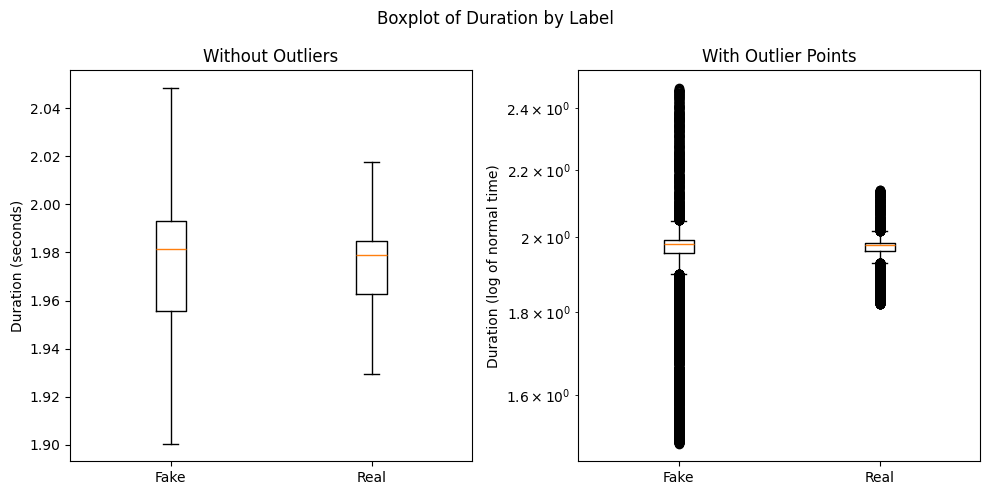

In [13]:
grouped_label_duration = [df[df["label"] == "fake"]["duration"], df[df["label"] == "real"]["duration"]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(grouped_label_duration, labels=["Fake", "Real"], showfliers=False)
axs[0].set_title("Without Outliers")
axs[0].set_ylabel("Duration (seconds)")

axs[1].boxplot(grouped_label_duration, labels=["Fake", "Real"])
axs[1].set_title("With Outlier Points")
axs[1].set_ylabel("Duration (log of normal time)")
axs[1].set_yscale("log")

fig.suptitle("Boxplot of Duration by Label")
plt.tight_layout()
plt.show()

Looks like we got rid of the outliers!! By removing outliers, we have now enhanced our model's performance by a large scale. Now, the maximum range form the minimum and maximum duration is only 0.9s which is an acceptable range that will not have strong influence on our model.

---

# Statistical Method 1 – Class Distribution Analysis (Bar Plot + Frequency Table)

For the first method, we first look at the `label` column in order to see the balance between both the `real` and the `fake` classes in the data. The main reason for this is to avoid bias.

To do this, we went with a bar plot in order to visualize the count/frequency of each, this was done thorugh `.value_counts` in the `pandas` library. The bar chart presented compares both the value counts of **real** and **fake** clips.

Our null hypothesis is that the distribution of real and fake audio samples  in the entire dataset is balanced; that is, both classes occur with approximately equal frequency. Our alternative hypothesis is that the distribution of real and fake audio samples in the dataset is imbalanced, in which one class occurs significantly more frequently than the other. We have chosen 0.05 as our significance level which means if the P-value is less than 0.05, we will reject the null hypothesis.



In [14]:
observed_fake_real_count = df['label'].value_counts().loc[['real','fake']].values

expected_fake_real_count = [len(df) / 2, len(df) / 2]
print(expected_fake_real_count, observed_fake_real_count)

stat, p_value = sc.chisquare(f_obs=observed_fake_real_count, f_exp=expected_fake_real_count)

print(f"Chi-square statistic: {stat:.2f}")
print(f"P-value: {p_value}")

[7014.5, 7014.5] [6200 7829]
Chi-square statistic: 189.15
P-value: 4.864116087822e-43


When looking at our p-value, it is clearly less than 0.05, which means that the real and fake audio samples are not balanced which may cause errors down the line. In order to fix this, we will process the data for both of the columns and will resample the fake types due to them being larger than the real ones. After that is done, we downsample the fake types so that they become equal to the real types.

In [15]:
from sklearn.utils import resample
df_real = df[df.label == 'real']
df_fake = df[df.label == 'fake']

df_fake_downsample = resample(df_fake, replace=False, n_samples=len(df_real), random_state=42)

df = pd.concat([df_real, df_fake_downsample])
df.reset_index(drop=True, inplace=True)
display(df)

,filepath,version,type,label,label_id,duration,samplerate
0,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,1.932500,16000
1,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.083188,16000
2,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.084125,16000
3,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.037500,16000
4,/content/drive/MyDrive/CMSC320/Project/for-nor...,norm,testing,real,1,2.028500,16000
...,...,...,...,...,...,...,...
12395,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,fake,0,1.997625,16000
12396,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,fake,0,1.972375,16000
12397,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,fake,0,2.023188,16000
12398,/content/drive/MyDrive/CMSC320/Project/for-rer...,rerec,training,fake,0,1.986438,16000


In [16]:
observed_fake_real_count = df['label'].value_counts().loc[['real','fake']].values

expected_fake_real_count = [len(df) / 2, len(df) / 2]
print(expected_fake_real_count, observed_fake_real_count)

stat, p_value = sc.chisquare(f_obs=observed_fake_real_count, f_exp=expected_fake_real_count)

print(f"Chi-square statistic: {stat:.2f}")
print(f"P-value: {p_value:.6f}")

[6200.0, 6200.0] [6200 6200]
Chi-square statistic: 0.00
P-value: 1.000000


After resampling our data, it is clear that now both types are balanced which is indicated by having a p_value > 0.05 which also means we fail to reject our null hypothesis.

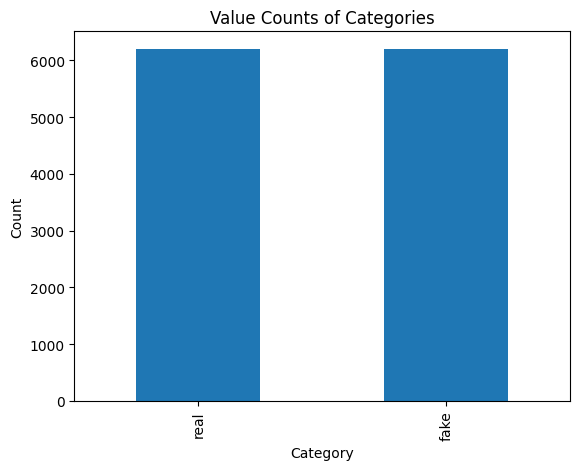

,count
label,
real,6200
fake,6200


In [17]:
fake_real_count = df['label'].value_counts()
fake_real_count.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of Categories')
plt.show()
fake_real_count

Since we now have balanced classes in our data, we can therefore confidently conclude that, when we train our model with this dataset, there is a high possibility that we will not see any biases that are caused by having non-balanced samples in our dataset. Doing this process also increases our chance of training a model that will give reliable results. This also makes the process simpler, as we will not have to resample or add weighting to our data later when we are in the process of training our model.

---

# Statistical Method 2 (Comparing Real vs Fake audio samples in different versions)

To have a better understanding of our dataset, we wanted to see if the balance between real and fake audio samples is similar across the two versions of data which are "norm" and "rerec". This is an important part for us to check because let's say for example, if one version has way more fake samples than real, there is a possibility that our model becomes biased and make poor predications.

We are going to use a 2-proportion z-test, which is a type of z-test that is specifically used to compare proportions, to test this. Our null hypothesis is that the proportion of fake audio samples and real audio samples is the same in both versions. Our alternative hypothesis is that either the proportion of fake audio samples or the proportion of real audio samples is larger than the other class in either of the version (norm or rerec). We have chosen 0.05 as our significance level which means if the P-value is less than 0.05, we will reject the null hypothesis. Since there are only two classes in our dataset (real or fake), we are going to test the proportion of fake audio samples out of all samples which will also reveal information about the proportion of real audio samples in the version column.

The 2-proportion z-test:

In [18]:
cont_table = pd.crosstab(df['version'], df['label'])

fake_samples = cont_table['fake'].values
total_samples = cont_table.sum(axis=1).values

statistic, pvalue = proportions_ztest(count = fake_samples, nobs = total_samples)

print(f"The z-test statistic:{statistic: .2f}")
print(f"The P-value:{pvalue:}")

The z-test statistic: 20.10
The P-value:6.834461146358374e-90


As we can see from the above calculation, the z-test gave us a statistic of 20.10 and a p-value of 6.83e-90. Since the p-value is 6.83e-90 which is significantly lower than our significance level of 0.05, we reject the null hypothesis. This helps us to conclude that the proportion of fake and real audio samples is not the same between the norm and rerec versions. We need to be careful about this when training our model. If our model starts giving unreliable result, this is something we should check/fix.

Here's a plot that shows how real and fake audio samples are distributed across norm and rerec versions:

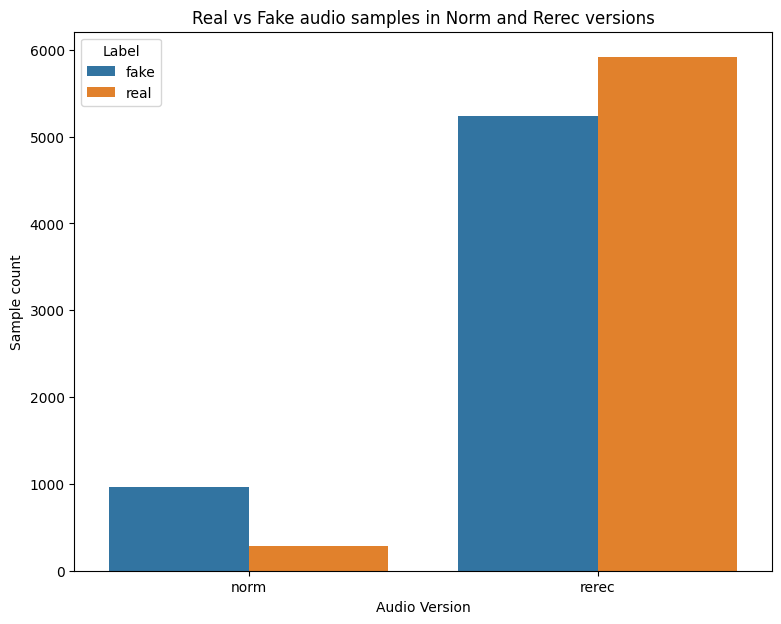

In [19]:
data = df.groupby(['version', 'label']).size().reset_index(name = 'samples')

plt.figure(figsize=(9,7))
sns.barplot(data = data, x = 'version', y = 'samples', hue = 'label')
plt.title('Real vs Fake audio samples in Norm and Rerec versions')
plt.xlabel('Audio Version')
plt.ylabel('Sample count')
plt.legend(title = 'Label')

plt.show()

# Statistical Method 3 (Audio duration across data splits)

To make sure our model performs better, we want to check if the average duration of audio samples is similar or atleast close in the training, testing, and validation sets. This is important because if one set has much longer or shorter audios on average than other sets, it might affect how our model learns and performs.

We are going to use an ANOVA test, which is a statistical method for comparing the means of three or more groups. Even though we could just look at the average values to see any difference, we believe ANOVA testing will help us check if the differences we are going to see are statistically meaningful or if they just happened by chance. This will give our conclusion more confidence and strong support.

Our null hypothesis is that the average audio durations are similar or close across training, testing, and validation sets. Our alternative hypothesis is that at least one of the data splits has a different average audio duration compared to the others. Even though the test checks for any difference, we will also look at the actual values to see if the difference is big enough to matter. We have chosen 0.05 as our significance level which means if the P-value is less than 0.05, we will reject the null hypothesis.


The ANOVA test:

In [20]:
train_data = df[df['type'] == 'training']['duration']
test_data = df[df['type'] == 'testing']['duration']
val_data = df[df['type'] == 'validation']['duration']

result = f_oneway(train_data, test_data, val_data)

print(f"The ANOVA test statistic:{result.statistic: .2f}")
print(f"The P-value:{result.pvalue: }")

The ANOVA test statistic: 137.32
The P-value: 1.0354307132125923e-59


From the above calculation, we can see that the ANOVA test gave us a statistic of 137.32 and a p-value of 1.04e-59. Since the p-value is 1.04e-59 which is significantly lower than our significance level of 0.05, we reject the null hypothesis. This means there is some statistical difference in average durations between the splits.

However, if we look at the actual average durations for each splits:

In [21]:
averages = df.groupby('type')['duration'].mean()
averages

,duration
type,
testing,1.926223
training,1.967017
validation,1.970423


we can see that, the differences are very small. So, even though ANOVA test showed us that there is a difference, by observing the values in the above table, we can say that the differences are not big enough to worry about. We can now conclude that the average audio duration is practically the same across all three splits (testing, training, validation) and it should not affect our model performance.

Here's a boxplot that shows the audio duration distribution for training, testing and validation sets:

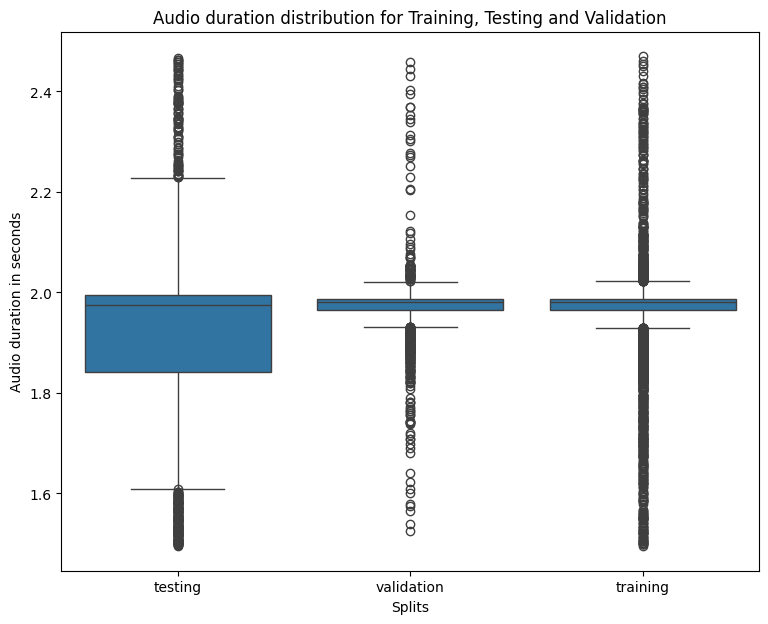

In [22]:
plt.figure(figsize=(9,7))
sns.boxplot(data = df, x = 'type', y = 'duration')
plt.title('Audio duration distribution for Training, Testing and Validation')
plt.xlabel('Splits')
plt.ylabel('Audio duration in seconds')
plt.show()

# Statistical Method 4 (Balance Across Splits + Statistical Testing)
Having similar numbers of real and fake audio samples within each of the training, testing, and validation sets is very important for training a fair and effective machine learning model. If one class for example, fake audio, have significantly more samples in any one of these sets than other classes, the model might become biased and perform poorly when trying to detect the classes with smaller samples in that set. So, to make sure the model learns fairly from both classes, we need to confirm that real and fake samples are balanced in each data split. To do that, we are using a statistical test called the Chi-square test to check if the numbers of real and fake sampels are same or atleast close across the training, testing, and validation sets.

Our null hypothesis is that the distribution of real and fake audio samples is similar/close for all the three data splits. Our alternative hypothesis is that the distribution is significantly different in atleast one split. We have chosen 0.05 as our significance level which means if the P-value is less than 0.05, we will reject the null hypothesis.

The Chi-Square test:

In [23]:
cont_table = pd.crosstab(df['type'], df['label'])

result = chi2_contingency(cont_table)

print(f"The Chi-square statistic:{result.statistic: .2f}")
print(f"The P-value:{result.pvalue:}")

The Chi-square statistic: 124.36
The P-value:9.905273641543375e-28


As we can see from the above calculation, the chi-square test gave us a statistic of 124.36 and a p-value of 9.91e-28. Since the p-value is 9.91e-28 which is significantly lower than our significance level of 0.05, we reject the null hypothesis.

This means that the class distribution is significantly differnt in atleast one split. From this table:

In [24]:
print(cont_table)

label       fake  real
type                  
testing     1125   687
training    4162  4546
validation   913   967


We can see that, there is a large difference in the number of fake testing samples vs real testing samples even though the distribution is close for training and validation sets. To fix this, we can do oversampling to balance the number of real and fake samples in the testing set by duplicating samples from the smaller class which is the "real" class. We are doing oversampling to make sure we have the same number of real and fake audio samples for testing so that our machine learning model doesn't get biased toward the class with more data. Even though oversampling will increase the number of real audio samples in our dataset, it's not a problem because the classes are still nearly balanced, and the model will get to learn fairly from both.

Oversampling process:

In [25]:
real_test_samples = df[(df['type'] == 'testing') & (df['label'] == 'real')]
fake_test_samples = df[(df['type'] == 'testing') & (df['label'] == 'fake')]

oversampling = resample(real_test_samples, replace=True, n_samples=len(fake_test_samples), random_state=42)

balanced_data = pd.concat([fake_test_samples, oversampling])

df = df[df['type'] != 'testing']
balanced_data['type'] = 'testing'
df = pd.concat([df, balanced_data])

After the oversampling process, we run the chi-square test again:

In [26]:
cont_table = pd.crosstab(df['type'], df['label'])

result = chi2_contingency(cont_table)

print(f"The Chi-square statistic:{result.statistic: .2f}")
print(f"The P-value:{result.pvalue:}")

The Chi-square statistic: 3.55
The P-value:0.16989615042231593


This time, the chi-square test has given us a statistic of 3.55 and a p-value of 0.17 (rounded value). Since the p-value is 0.17 which is higher than our significance level of 0.05, we fail to reject the null hypothesis. Now, we can confidently conclude that there is no significant difference in how real and fake audio samples are distributed across the splits. This balance is good because it will help the model learn from all parts of the data fairly and will give us reliable and unbiased predications.

Here's a plot that shows the distribution of real and fake audio samples in testing, training, and validation sets:

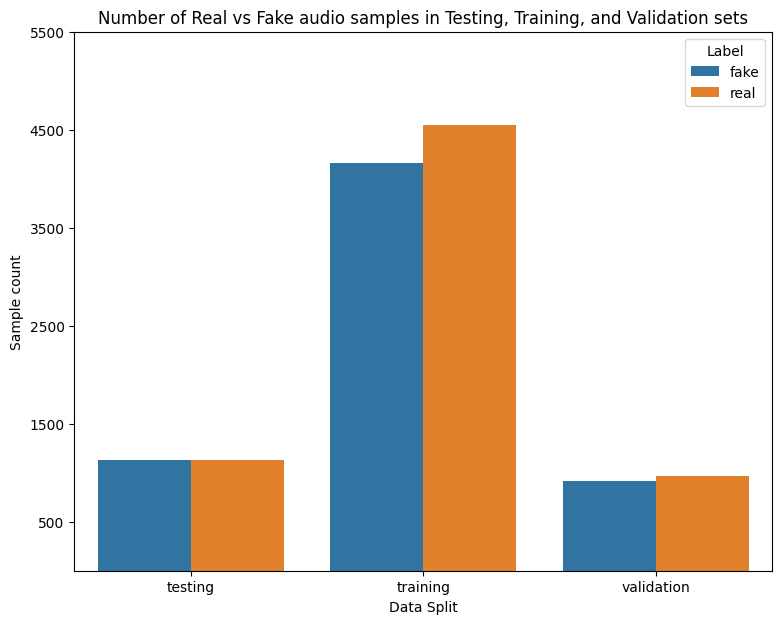

In [27]:
data = df.groupby(['type', 'label']).size().reset_index(name = 'samples')

plt.figure(figsize=(9,7))
sns.barplot(data = data, x = 'type', y = 'samples', hue = 'label')
plt.title('Number of Real vs Fake audio samples in Testing, Training, and Validation sets')
plt.xlabel('Data Split')
plt.ylabel('Sample count')
plt.legend(title = 'Label')
plt.yticks(([500, 1500, 2500, 3500, 4500, 5500]))

plt.show()